# Train LSTM network using detected keypoints from 

## Import libraries

In [1]:
# Basic functions
import os
import torch
import numpy as np
import re
from importlib import reload

# Training/Test Set Creation - to use later
from sklearn.model_selection import StratifiedShuffleSplit

# Dataset Creation
from collections import Counter
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

# Model Training and Definition
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import trainutils_leon
import vidutils_leon

# Create Training and Test Sets

### Load real edited videos
Define classes and preview. Choose between using synthetic data, real data or both.

In [13]:
# Choose datasets to use
real_data = True
syn_data = False

X_paths = [] # paths of segment folders
y = [] # designated label

if real_data:
    # Specify directories
    frame_folder = "./data/frames"
    # Construct X = folder names, y = the label
    vf_list = os.listdir(frame_folder)

    for vf_folder in vf_list:
        # Create path to video
        vf_path = os.path.join(frame_folder, vf_folder)
        print("Current Video: "+ vf_folder)

        # Get individual segment folder
        segfolder_list = os.listdir(vf_path)

        # Check every segment folder
        for seg_folder in segfolder_list:

            #print(seg_folder)
            x_path = os.path.join(vf_path, seg_folder)
            #print(x_path)
            X_paths.append(x_path + '/features.npz')

            # Extract class label from folder name
            label = int(seg_folder.split("_")[2])
            #print(label)
            y.append(label) # x 100 + 100

if syn_data:
    # define synthetic data directory
    output_dir = './synthetic_data/output'
    output_list = os.listdir(output_dir)

    for output_folder in output_list:
        if output_folder.startswith('vid'):
            x_path = output_dir + '/' + output_folder
            X_paths.append(x_path)

            # Extract class label from folder name
            params = re.findall(r'\d+', output_folder)
            label = int( (int(params[3]) - 1) / 100)
            y.append(label)
    
# Display video count and classes
len(X_paths), len(y), Counter(y)

Current Video: video3
Current Video: video4
Current Video: video2
Current Video: video1


(504,
 504,
 Counter({3: 50,
          4: 50,
          6: 48,
          1: 54,
          5: 51,
          8: 52,
          2: 49,
          9: 52,
          0: 48,
          7: 50}))

###  Convert to Pytorch Dataset
Load data and split into training and test.

In [14]:
# Split into training and test sets
splitter = StratifiedShuffleSplit(n_splits = 2, test_size = 0.1, random_state = 0)
train_set, test_set = next(splitter.split(X_paths, y))

# Training Set
train_X_paths = [X_paths[i] for i in train_set]
train_ys = [y[i] for i in train_set]
print("Training Set: ({0},{1})".format(len(train_X_paths), len(train_ys)))

# Test Set
test_X_paths = [X_paths[i] for i in test_set]
test_ys = [y[i] for i in test_set]
print("Test Set: ({0},{1})".format(len(test_X_paths), len(test_ys)))

Training Set: (453,453)
Test Set: (51,51)


Define dataset class and types of normalization to use on data

In [5]:
# Define Dataset Class
class SyncDataset(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.X = X
        self.y = y
    
    # Returns length
    def __len__(self):
        return len(self.X)
    
    # Returns X feature array and y value
    def __getitem__(self, idx):
        
        # Load npz file
        npz_path = self.X[idx]
        data = np.load(npz_path)
        num_frames = 20
        
        # extract features
        if npz_path.startswith('./data/'):
            X_feat = data['feature_array']
        else:
            X_feat = vidutils_leon.reshape_syn_features \
            (data['subset_all'][:num_frames], data['candidate_all'][:num_frames])
        
         # apply transform
        if self.transform:
            X_tensor = self.transform(X_feat).squeeze().float()
        else:
            # Convert X to tensor
            X_tensor = torch.from_numpy(X_feat).float()
        
        return X_tensor, self.y[idx] # y_tensor

In [6]:
# Define normalization functions
class norm_per_subj(object):
    """
    Rescale features are between 0 and 1 for each subject. 
    Each frame is over each subject's features.
    """
    def __call__(self, sample):
        # squeeze tensor
        sample = sample.squeeze()
        # normalize
        sub1 = normalize(sample[:,0:56], axis=1)
        sub2 = normalize(sample[:,56:112], axis=1)
        sub3 = normalize(sample[:,112:168], axis=1)
        # recombine subjects
        scaled_sample = np.concatenate((sub1, sub2, sub3),axis=1)
        return scaled_sample
    
class norm_all_subj(object):
    """
    Rescale features are between 0 and 1 for each subject.
    Each frame is normalized over features of all subjects
    """
    def __call__(self, sample):
        # squeeze tensor
        sample = sample.squeeze()
        # normalize
        scaled_sample = normalize(sample, axis=1)
        return scaled_sample

class norm_with_saved(object):
    """
    Rescale each feature by subtracting mean and dividing by SD over all subjects
    IMPORTANT: Calculate saved_mean and saved_std first.
    """
    def __call__(self, sample):
        # squeeze tensor
        sample = sample.squeeze()
        # normalize
        scaled_sample = (sample - saved_mean)/saved_std
        return scaled_sample

Load datasets into the defined dataset class

In [7]:
# precalculate means and std
dataset = []
training_dataset = SyncDataset(X = train_X_paths, y = train_ys)
for train_X, train_y in training_dataset:
    new_row = train_X.data.numpy()
    if len(dataset) == 0:
        dataset = new_row
    else:
        dataset = np.vstack((dataset,new_row))
saved_mean = np.mean(dataset, axis=0) 
saved_std = np.std(dataset, axis=0) 
saved_std[saved_std == 0] = 0.00001 # prevent error dividing by 0

# Define Transformer
transformer = transforms.Compose([
    norm_with_saved(),
    transforms.ToTensor()
])

# Define Training Dataset 
training_dataset = SyncDataset(X = train_X_paths, y = train_ys, transform = transformer)

# Define Test Dataset
testing_dataset = SyncDataset(X = test_X_paths, y = test_ys, transform = transformer)

In [8]:
# Grab a row to see contents
sample_X, sample_y = training_dataset[2]
print(sample_X.shape, sample_y)
sample_X[2,3:6]

torch.Size([20, 168]) 6


tensor([ 1.3554,  1.4152, -0.1980])

### Define Data Loader  
Data Loader for extracting batches from the Pytorch Dataset during model training

In [9]:
def batch_collater(batch):
    X_batch, y_batch = list(zip(*batch))
    
    # Separate batch into X and y
    X_batch = [x for x in X_batch if len(x) > 0]
    y_batch = [torch.tensor(y) for y, x in zip(y_batch, X_batch) if len(x) > 0]
    
    # Convert into tensors
    X_tensor = torch.stack(X_batch)
    y_tensor = torch.stack(y_batch).long()
    
    return X_tensor, y_tensor

In [10]:
# Specify batch size
batch_size = 30

training_loader = DataLoader(training_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)
testing_loader = DataLoader(testing_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)

# check shapes
for xb, yb in training_loader:
    print(xb.shape, yb.shape)
    break

for xb, yb in testing_loader:
    print(xb.shape, yb.shape)
    break

torch.Size([30, 20, 168]) torch.Size([30])
torch.Size([30, 20, 168]) torch.Size([30])


# Model Definition 
Define LSTM architecture.

In [12]:
class SyncRNN(nn.Module):
    
    def __init__(self, params_model):
        
        super(SyncRNN, self).__init__()
        
        # Import Model Parameters
        num_classes = params_model["num_classes"]
        dr_rate = params_model["dr_rate"] # dropout rate
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        num_features = 168
        batchsize = 1
        
        # Define Model Structure
        self.dropout = nn.Dropout(dr_rate)
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
        
    def forward(self, x):
        
        # batch count, frame count, feature size
        batch_count, frame_count, feature_size = x.shape
        frame_idx = 0
        
        # Reshape the frame
        shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
        
        # Feed the first frame into the rnn
        output, (hn, cn) = self.rnn(shaped_frame)
        
        # Feed the rest of the frames 
        for frame_idx in range(1, frame_count):
            shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
            output, (hn, cn) = self.rnn(shaped_frame, (hn, cn))
        
        #output = self.dropout(output[:,-1])
        output = self.fc1(output)
        
        return output

## Model Training  

### Define loss function and optimizer to train the model

Table of tested params:

|  S/N  |  data  |  dr  |  layers  |  hidden_size  |  epochs  |   lr   |    loss     |  train_acc  |  test_acc | 
|-------|--------|------|----------|---------------|----------|--------|-------------|-------------|-----------|
|   1   |  real  |   0  |    1     |      300      |    100   |  3e-3  |   CE: 2.28  |      13     |     13    |
|   2   |  syn   |   0  |    1     |      300      |    30    |  3e-3  |   CE: 2.6   |      10     |     10    |
|   3   |  syn   |   0  |    1     |      300      |    30    |  0.1   |   CE: 2.45  |      10     |     10    |
|   4   |  syn   |   0  |    1     |      100      |    30    |  0.1   |   CE: 2.39  |      10     |     10    |
|   5   |  syn   |   0  |    1     |      100      |    200   |  0.1   |  MSE: 8.04  |      9.8    |     9.8   |
|   6   |  syn   |   0  |    1     |      300      |    200   |  0.1   |  MSE: 8.04  |      9.8    |     9.8   |
|   7   |  syn   |   0  |    1     |      100      |    200   |  3e-3  |  MSE: 8.04  |      9.8    |     9.8   |
|   8   |  real  |   0  |    1     |      100      |    200   |  3e-3  |  MSE: 20.7  |      9.8    |     9.8   |
|   9   |  real  |   0  |    1     |      100      |    200   |  3     |  MSE: 8.3   |      7.8    |     7.8   |
|   10  |r_inorm |   0  |    1     |      100      |    200   |  3     |  MSE: 8.3   |      9.8    |     9.8   |
|   11  |r_fnorm |   0  |    1     |      100      |    70    |  0.1   |  MSE: 8.3   |      9.8    |     9.8   |
|   12  |r_snorm |   0  |    1     |      100      |    70    |  0.1   |   CE: 1.5   |      40     |     19    |
|   13  |r_snorm |   0  |    1     |      100      |    70    |  0.1   |  MSE: 1.5   |      23     |     23.5  |
|   14  |r_snorm |   0  |    1     |      100      |    200   |  0.1   |   CE: 1.4   |      50     |     23    |
|   15  |r_snorm |   0  |    1     |      200      |    200   |  0.1   |   CE: 1.4   |      50     |     20    |
|   16  |r_snorm |   0  |    2     |      100      |    200   |  0.1   |   CE: 1.5   |      35     |     20    |
|   17  |s_snorm |   0  |    1     |      100      |    200   |  0.1   |   CE: 1.5   |      35     |     20    |
|   18  |sr_snorm|   0  |    1     |      100      |    200   |  0.1   |   CE: 1.8   |      35     |     15    |
|   19  |sr_snorm|   0  |    1     |      100      |    200   |  0.1   |   MSE:6.7   |      14     |     14    |
|   20  |sr_snorm|   0  |    1     |      100      |    200   |  0.1   |   L1: 2.2   |      14     |     14    |
|   21  |  real  |   0  |    1     |      100      |    200   |  0.1   |   L1: 1.25  |      25     |     35    |

Choose whether to use classification model or regression model

In [28]:
# Choose whether to use classification model or regression model
classif_model = False
reg_model = True

# Define Loss Function
if classif_model:
    loss_fn = nn.CrossEntropyLoss(reduction="sum")
    weight_path = "./models/weights_real_ce.pt"
    num_class = 10

if reg_model:
    # choose between L1 and MSE
    #loss_fn = nn.L1Loss(reduction="sum")
    loss_fn = nn.MSELoss(reduction="sum")
    weight_path = "./models/weights_real_mse.pt"
    num_class = 1

# RNN Model Parameter
model_params = {
    "num_classes": num_class,
    "dr_rate": 0.0,
    "rnn_num_layers": 1,
    "rnn_hidden_size": 100,
}
model = SyncRNN(model_params)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [29]:
# Print Model Params
model = model.to(device)
model

SyncRNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (rnn): LSTM(168, 100)
  (fc1): Linear(in_features=100, out_features=1, bias=True)
)

In [30]:
# Test Model with dummy input
with torch.no_grad():
    x = torch.randn(1, 20, 168)
    y = model(x)
    print(y.shape) # should be [1,1,10] for classification or [1,1,1] for regression

torch.Size([1, 1, 1])


In [31]:
# Define Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr = 0.1)

# Define LR Scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience = 5, verbose=1)
os.makedirs("./models", exist_ok=True)

# Define Training Parameters - tweak this
train_params = {
    "num_epochs": 100,
    "optimizer": optimizer,
    "loss_fn": loss_fn,
    "training_loader": training_loader,
    "testing_loader": testing_loader,
    "lr_scheduler": lr_scheduler,
    "weights_path": weight_path,
}

## Train network and display train/test accuracies

In [32]:
if classif_model:
    trained_model, loss_hist, metric_hist = trainutils_leon.train_model(model, train_params)
if reg_model:
    trained_model, loss_hist, metric_hist = trainutils_leon.train_model_mse(model, train_params)

Epoch 0/99, current_lr=0.1



Saved best model weights
Train Loss: 11.405407, Dev Loss: 10.170542, Accuracy: 11.76
----------
Epoch 1/99, current_lr=0.1



Saved best model weights
Train Loss: 8.097387, Dev Loss: 8.449853, Accuracy: 15.69
----------
Epoch 2/99, current_lr=0.1



Saved best model weights
Train Loss: 7.373562, Dev Loss: 8.210485, Accuracy: 11.76
----------
Epoch 3/99, current_lr=0.1



Saved best model weights
Train Loss: 6.523288, Dev Loss: 6.995812, Accuracy: 13.73
----------
Epoch 4/99, current_lr=0.1



Train Loss: 6.725699, Dev Loss: 7.548937, Accuracy: 17.65
----------
Epoch 5/99, current_lr=0.1



Train Loss: 6.651225, Dev Loss: 8.342751, Accuracy: 9.80
----------
Epoch 6/99, current_lr=0.1



Train Loss: 7.321697, Dev Loss: 7.153811, Accuracy: 19.61
----------
Epoch 7/99, current_lr=0.1



Train Loss: 6.979641, Dev Loss: 10.227684, Accuracy: 11.76
----------
Epoch 8/99, current_lr=0.1



Train Loss: 6.576682, Dev Loss: 8.255103, Accuracy: 9.80
----------
Epoch 9/99, current_lr=0.1



Epoch     9: reducing learning rate of group 0 to 7.0000e-02.
Loading best model weights
Train Loss: 6.580056, Dev Loss: 8.564622, Accuracy: 15.69
----------
Epoch 10/99, current_lr=0.06999999999999999



Train Loss: 6.508111, Dev Loss: 8.177832, Accuracy: 13.73
----------
Epoch 11/99, current_lr=0.06999999999999999



Train Loss: 5.887889, Dev Loss: 8.572085, Accuracy: 15.69
----------
Epoch 12/99, current_lr=0.06999999999999999



Train Loss: 5.787512, Dev Loss: 7.621446, Accuracy: 9.80
----------
Epoch 13/99, current_lr=0.06999999999999999



Train Loss: 6.004852, Dev Loss: 8.067352, Accuracy: 13.73
----------
Epoch 14/99, current_lr=0.06999999999999999



Train Loss: 6.478317, Dev Loss: 9.610016, Accuracy: 19.61
----------
Epoch 15/99, current_lr=0.06999999999999999



Epoch    15: reducing learning rate of group 0 to 4.9000e-02.
Loading best model weights
Train Loss: 5.722332, Dev Loss: 8.279586, Accuracy: 15.69
----------
Epoch 16/99, current_lr=0.048999999999999995



Train Loss: 5.761512, Dev Loss: 7.121371, Accuracy: 7.84
----------
Epoch 17/99, current_lr=0.048999999999999995



Train Loss: 5.712492, Dev Loss: 7.620546, Accuracy: 13.73
----------
Epoch 18/99, current_lr=0.048999999999999995



Train Loss: 5.537603, Dev Loss: 7.605810, Accuracy: 11.76
----------
Epoch 19/99, current_lr=0.048999999999999995



Train Loss: 5.067857, Dev Loss: 8.554293, Accuracy: 13.73
----------
Epoch 20/99, current_lr=0.048999999999999995



Train Loss: 5.101308, Dev Loss: 7.831097, Accuracy: 21.57
----------
Epoch 21/99, current_lr=0.048999999999999995



Epoch    21: reducing learning rate of group 0 to 3.4300e-02.
Loading best model weights
Train Loss: 5.078584, Dev Loss: 7.111218, Accuracy: 19.61
----------
Epoch 22/99, current_lr=0.0343



Train Loss: 6.182042, Dev Loss: 8.140428, Accuracy: 9.80
----------
Epoch 23/99, current_lr=0.0343



Train Loss: 5.008834, Dev Loss: 7.793584, Accuracy: 15.69
----------
Epoch 24/99, current_lr=0.0343



Train Loss: 5.461045, Dev Loss: 7.726107, Accuracy: 23.53
----------
Epoch 25/99, current_lr=0.0343



Train Loss: 4.928912, Dev Loss: 7.906381, Accuracy: 11.76
----------
Epoch 26/99, current_lr=0.0343



Train Loss: 4.826279, Dev Loss: 8.540860, Accuracy: 9.80
----------
Epoch 27/99, current_lr=0.0343



Epoch    27: reducing learning rate of group 0 to 2.4010e-02.
Loading best model weights
Train Loss: 4.834941, Dev Loss: 8.470153, Accuracy: 3.92
----------
Epoch 28/99, current_lr=0.024009999999999997



Train Loss: 6.045505, Dev Loss: 9.144467, Accuracy: 9.80
----------
Epoch 29/99, current_lr=0.024009999999999997



Train Loss: 5.450478, Dev Loss: 7.587997, Accuracy: 21.57
----------
Epoch 30/99, current_lr=0.024009999999999997



Train Loss: 5.170027, Dev Loss: 8.399993, Accuracy: 11.76
----------
Epoch 31/99, current_lr=0.024009999999999997



Train Loss: 4.857686, Dev Loss: 7.761157, Accuracy: 5.88
----------
Epoch 32/99, current_lr=0.024009999999999997



Train Loss: 4.844802, Dev Loss: 8.707117, Accuracy: 17.65
----------
Epoch 33/99, current_lr=0.024009999999999997



Epoch    33: reducing learning rate of group 0 to 1.6807e-02.
Loading best model weights
Train Loss: 4.717126, Dev Loss: 7.879471, Accuracy: 13.73
----------
Epoch 34/99, current_lr=0.016806999999999996



Train Loss: 6.113058, Dev Loss: 7.921898, Accuracy: 9.80
----------
Epoch 35/99, current_lr=0.016806999999999996



Saved best model weights
Train Loss: 5.627846, Dev Loss: 6.437553, Accuracy: 13.73
----------
Epoch 36/99, current_lr=0.016806999999999996



Train Loss: 5.161756, Dev Loss: 7.756412, Accuracy: 13.73
----------
Epoch 37/99, current_lr=0.016806999999999996



Train Loss: 4.955803, Dev Loss: 7.485535, Accuracy: 13.73
----------
Epoch 38/99, current_lr=0.016806999999999996



Train Loss: 4.600825, Dev Loss: 6.953885, Accuracy: 17.65
----------
Epoch 39/99, current_lr=0.016806999999999996



Train Loss: 4.381683, Dev Loss: 7.508046, Accuracy: 13.73
----------
Epoch 40/99, current_lr=0.016806999999999996



Train Loss: 4.141984, Dev Loss: 6.971930, Accuracy: 9.80
----------
Epoch 41/99, current_lr=0.016806999999999996



Epoch    41: reducing learning rate of group 0 to 1.1765e-02.
Loading best model weights
Train Loss: 4.374756, Dev Loss: 7.067154, Accuracy: 15.69
----------
Epoch 42/99, current_lr=0.011764899999999997



Train Loss: 5.095650, Dev Loss: 8.186608, Accuracy: 9.80
----------
Epoch 43/99, current_lr=0.011764899999999997



Saved best model weights
Train Loss: 4.683739, Dev Loss: 5.951361, Accuracy: 9.80
----------
Epoch 44/99, current_lr=0.011764899999999997



Train Loss: 4.797851, Dev Loss: 6.420939, Accuracy: 13.73
----------
Epoch 45/99, current_lr=0.011764899999999997



Train Loss: 4.565468, Dev Loss: 6.678032, Accuracy: 7.84
----------
Epoch 46/99, current_lr=0.011764899999999997



Train Loss: 4.485448, Dev Loss: 6.388260, Accuracy: 19.61
----------
Epoch 47/99, current_lr=0.011764899999999997



Train Loss: 4.247360, Dev Loss: 6.802394, Accuracy: 17.65
----------
Epoch 48/99, current_lr=0.011764899999999997



Train Loss: 4.239139, Dev Loss: 6.916201, Accuracy: 13.73
----------
Epoch 49/99, current_lr=0.011764899999999997



Epoch    49: reducing learning rate of group 0 to 8.2354e-03.
Loading best model weights
Train Loss: 4.024487, Dev Loss: 7.830699, Accuracy: 13.73
----------
Epoch 50/99, current_lr=0.008235429999999997



Train Loss: 4.433341, Dev Loss: 6.135376, Accuracy: 13.73
----------
Epoch 51/99, current_lr=0.008235429999999997



Train Loss: 4.656704, Dev Loss: 6.950313, Accuracy: 23.53
----------
Epoch 52/99, current_lr=0.008235429999999997



Train Loss: 4.194393, Dev Loss: 6.962587, Accuracy: 13.73
----------
Epoch 53/99, current_lr=0.008235429999999997



Train Loss: 4.391827, Dev Loss: 6.660052, Accuracy: 17.65
----------
Epoch 54/99, current_lr=0.008235429999999997



Train Loss: 4.249308, Dev Loss: 7.095627, Accuracy: 15.69
----------
Epoch 55/99, current_lr=0.008235429999999997



Epoch    55: reducing learning rate of group 0 to 5.7648e-03.
Loading best model weights
Train Loss: 4.292591, Dev Loss: 7.719568, Accuracy: 15.69
----------
Epoch 56/99, current_lr=0.005764800999999997



Train Loss: 4.670721, Dev Loss: 6.934629, Accuracy: 7.84
----------
Epoch 57/99, current_lr=0.005764800999999997



Train Loss: 4.432036, Dev Loss: 6.615873, Accuracy: 21.57
----------
Epoch 58/99, current_lr=0.005764800999999997



Train Loss: 4.445103, Dev Loss: 6.538313, Accuracy: 15.69
----------
Epoch 59/99, current_lr=0.005764800999999997



Train Loss: 4.667377, Dev Loss: 7.069624, Accuracy: 11.76
----------
Epoch 60/99, current_lr=0.005764800999999997



Saved best model weights
Train Loss: 3.903268, Dev Loss: 5.935917, Accuracy: 17.65
----------
Epoch 61/99, current_lr=0.005764800999999997



Train Loss: 4.371236, Dev Loss: 6.081378, Accuracy: 21.57
----------
Epoch 62/99, current_lr=0.005764800999999997



Train Loss: 4.248651, Dev Loss: 6.078858, Accuracy: 19.61
----------
Epoch 63/99, current_lr=0.005764800999999997



Train Loss: 4.227717, Dev Loss: 6.310427, Accuracy: 13.73
----------
Epoch 64/99, current_lr=0.005764800999999997



Train Loss: 3.905262, Dev Loss: 6.725381, Accuracy: 13.73
----------
Epoch 65/99, current_lr=0.005764800999999997



Train Loss: 4.053343, Dev Loss: 7.045355, Accuracy: 17.65
----------
Epoch 66/99, current_lr=0.005764800999999997



Epoch    66: reducing learning rate of group 0 to 4.0354e-03.
Loading best model weights
Train Loss: 3.518910, Dev Loss: 6.126186, Accuracy: 15.69
----------
Epoch 67/99, current_lr=0.004035360699999998



Train Loss: 4.212575, Dev Loss: 6.746420, Accuracy: 17.65
----------
Epoch 68/99, current_lr=0.004035360699999998



Train Loss: 4.158734, Dev Loss: 7.624692, Accuracy: 15.69
----------
Epoch 69/99, current_lr=0.004035360699999998



Train Loss: 4.135089, Dev Loss: 6.087567, Accuracy: 9.80
----------
Epoch 70/99, current_lr=0.004035360699999998



Train Loss: 3.965192, Dev Loss: 5.988359, Accuracy: 15.69
----------
Epoch 71/99, current_lr=0.004035360699999998



Train Loss: 3.792504, Dev Loss: 6.807798, Accuracy: 11.76
----------
Epoch 72/99, current_lr=0.004035360699999998



Epoch    72: reducing learning rate of group 0 to 2.8248e-03.
Loading best model weights
Train Loss: 3.842890, Dev Loss: 6.168125, Accuracy: 17.65
----------
Epoch 73/99, current_lr=0.0028247524899999983



Train Loss: 4.270286, Dev Loss: 6.607674, Accuracy: 19.61
----------
Epoch 74/99, current_lr=0.0028247524899999983



Train Loss: 4.166529, Dev Loss: 7.272918, Accuracy: 19.61
----------
Epoch 75/99, current_lr=0.0028247524899999983



Train Loss: 3.885246, Dev Loss: 6.840865, Accuracy: 19.61
----------
Epoch 76/99, current_lr=0.0028247524899999983



Train Loss: 4.005093, Dev Loss: 7.178564, Accuracy: 17.65
----------
Epoch 77/99, current_lr=0.0028247524899999983



Train Loss: 3.937752, Dev Loss: 6.622167, Accuracy: 9.80
----------
Epoch 78/99, current_lr=0.0028247524899999983



Saved best model weights
Train Loss: 3.958975, Dev Loss: 5.861758, Accuracy: 17.65
----------
Epoch 79/99, current_lr=0.0028247524899999983



Train Loss: 3.825010, Dev Loss: 6.524966, Accuracy: 15.69
----------
Epoch 80/99, current_lr=0.0028247524899999983



Saved best model weights
Train Loss: 3.778470, Dev Loss: 5.806247, Accuracy: 9.80
----------
Epoch 81/99, current_lr=0.0028247524899999983



Train Loss: 3.979155, Dev Loss: 6.802247, Accuracy: 13.73
----------
Epoch 82/99, current_lr=0.0028247524899999983



Train Loss: 3.546725, Dev Loss: 6.075349, Accuracy: 11.76
----------
Epoch 83/99, current_lr=0.0028247524899999983



Train Loss: 3.856400, Dev Loss: 6.803303, Accuracy: 21.57
----------
Epoch 84/99, current_lr=0.0028247524899999983



Train Loss: 3.727046, Dev Loss: 7.214811, Accuracy: 9.80
----------
Epoch 85/99, current_lr=0.0028247524899999983



Train Loss: 3.714750, Dev Loss: 7.124534, Accuracy: 19.61
----------
Epoch 86/99, current_lr=0.0028247524899999983



Epoch    86: reducing learning rate of group 0 to 1.9773e-03.
Loading best model weights
Train Loss: 3.688116, Dev Loss: 6.698905, Accuracy: 17.65
----------
Epoch 87/99, current_lr=0.0019773267429999985



Train Loss: 3.727453, Dev Loss: 6.185832, Accuracy: 23.53
----------
Epoch 88/99, current_lr=0.0019773267429999985



Train Loss: 3.767130, Dev Loss: 6.520307, Accuracy: 17.65
----------
Epoch 89/99, current_lr=0.0019773267429999985



Train Loss: 3.802495, Dev Loss: 6.970886, Accuracy: 15.69
----------
Epoch 90/99, current_lr=0.0019773267429999985



Train Loss: 3.831681, Dev Loss: 6.070218, Accuracy: 19.61
----------
Epoch 91/99, current_lr=0.0019773267429999985



Saved best model weights
Train Loss: 3.766997, Dev Loss: 5.597120, Accuracy: 9.80
----------
Epoch 92/99, current_lr=0.0019773267429999985



Train Loss: 3.670667, Dev Loss: 5.649297, Accuracy: 21.57
----------
Epoch 93/99, current_lr=0.0019773267429999985



Train Loss: 3.781534, Dev Loss: 6.347813, Accuracy: 13.73
----------
Epoch 94/99, current_lr=0.0019773267429999985



Train Loss: 3.665025, Dev Loss: 7.215288, Accuracy: 17.65
----------
Epoch 95/99, current_lr=0.0019773267429999985



Train Loss: 3.522676, Dev Loss: 6.157794, Accuracy: 19.61
----------
Epoch 96/99, current_lr=0.0019773267429999985



Train Loss: 3.564785, Dev Loss: 6.697978, Accuracy: 13.73
----------
Epoch 97/99, current_lr=0.0019773267429999985



Epoch    97: reducing learning rate of group 0 to 1.3841e-03.
Loading best model weights
Train Loss: 3.639030, Dev Loss: 6.185472, Accuracy: 21.57
----------
Epoch 98/99, current_lr=0.0013841287200999988



Train Loss: 3.696914, Dev Loss: 6.908517, Accuracy: 13.73
----------
Epoch 99/99, current_lr=0.0013841287200999988



Train Loss: 3.852682, Dev Loss: 5.898041, Accuracy: 21.57
----------


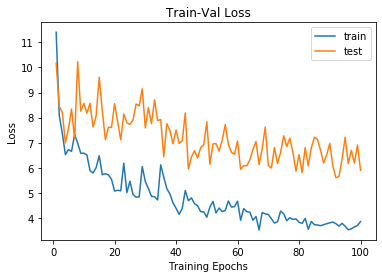

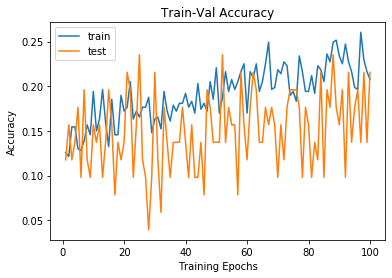

In [33]:
trainutils_leon.plot_loss(loss_hist, metric_hist)